<h1><center><font color='blue'>Usando droput en la regresión</font></center></h1>


<h3>Objetivos<h3>    
<h5> 1. Crear el modelo y la función de costo</h5>
<h5> 2. Aprender Batch Gradient Descent </h5>    


<h2>Tabla de contenido</h2>

<ul>
    <li><a href="#Makeup_Data">Crear algunos datos</a></li>
    <li><a href="#Model_Cost">Crear el modelo y la función de costo</a></li>
    <li><a href="#BGD">Batch Gradient Descent</a></li>
</ul>

<hr>


<h2>Preparación</h2>


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0) 

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Crear algunos datos</h2>


Crear una clase dataset polinomial:


In [3]:
# Create Data object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x ** 2
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='orange')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

Crear un objeto dataset:


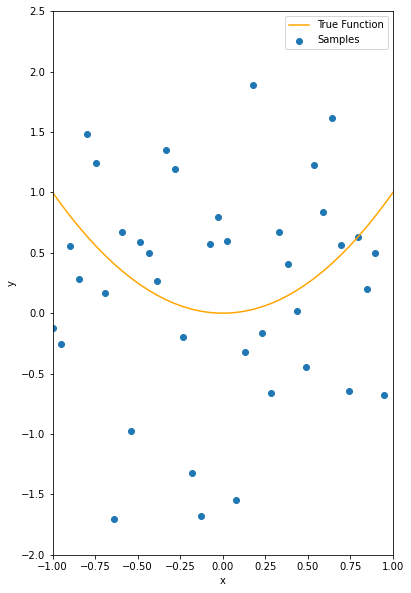

In [4]:
# Create the dataset object and plot the dataset

data_set = Data()
data_set.plot()

Obtener algunos datos de validación:


In [5]:
# Create validation dataset object

validation_set = Data(train=False)

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Crear el modelo, optimizador y costo</h2>


Creamos un módulo personalizado con 3 capas. <code>in_size</code> es el tamaño de las características de entrada, <code>n_hidden</code> el tamaño de las capas y <code>out_size</code> el tamaño de la salida. <code>p</code> es la probabilidad de droput. Por defecto tiene el valor 0, que corresponde a no haya dropout.


In [6]:
# Create the class for model

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

Creamos 2 objetos modelo: <code>model</code> que no tiene droput y <code>model_drop</code> que sí lo tiene, con probabilidad de 0.5:


In [7]:
# Create the model objects

model = Net(1, 300, 1)
model_drop = Net(1, 300, 1, p=0.5)

<!--Empty Space for separating topics-->


<h2 id="Train">Entrenamos el modelo vía Mini-Batch Gradient Descent</h2>


Establecemos el modelo usando dropou para el modo de entrenamiento:


In [8]:
# Set the model to train mode

model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Entrenamos el modelo usando el optimizador ADAM. Para la pérdida usamos MSE.


In [9]:
# Set the optimizer and criterion function

optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

Inicializamos un diccionario que almacena las pérdidas de entrenamiento y validación para cada modelo:

In [10]:
# Initialize the dict to contain the loss results

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

Ejecutamos 500 iteraciones de batch gradient descent: 


In [11]:
# Train the model

epochs = 500

def train_model(epochs):
    for epoch in range(epochs):
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for  both the training and validation  data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()
        
train_model(epochs)

Establecemos el modelo con droput para modo evaluación:


In [12]:
# Set the model with dropout to evaluation mode

model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Realizamos una predicción para ambos modelos:


In [13]:
# Make the prediction

yhat = model(data_set.x)
yhat_drop = model_drop(data_set.x)

Graficamos las predicciones para ambos modelos. Comparamos con los puntos de entrenamiento y la función real:


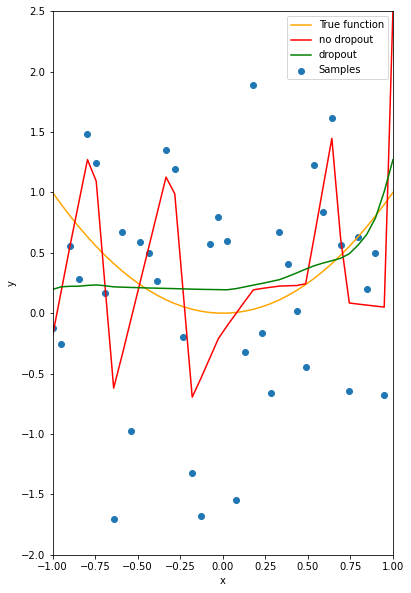

In [14]:
# Plot the predictions for both models

plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
plt.plot(data_set.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(data_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

Se ve que el modelo con droput sigue mejor la función que genera los datos.


Graficamos las pérdidas de entrenamiento y validación para ambos modelos: 


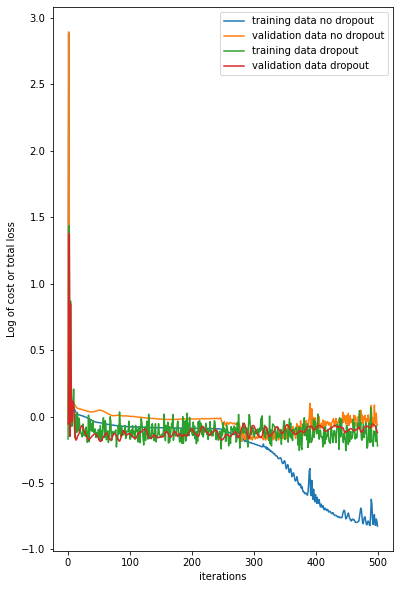

In [15]:
# Plot the loss

plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

El modelo sin droput tiene una mejor perfomance con los datos de entrenamiento que con los de validación; esto sugiere overfitting. El modelo con droput tiene una mejor performance con los datos de validación que con los de entrenamiento.
